In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# To Do
- include bb and rexp
- display buttons in visualization
- create multicolor lines (https://matplotlib.org/examples/pylab_examples/multicolored_line.html)
    - Zeit durch Alpha-Wert codieren
- decrease image saturation to improve line visibility
- verweildauer (zeit bis zum nächsten Datenpunkt) codieren - Größe des Punktes?

In [11]:
def find_file(suffix, path):
    """
    return the filename of the log file
    """
    result_files = []
    for root, dirs, files in os.walk(path):
        for file in [f for f in files if f.endswith(suffix)]:
            result_files.append(file)
    return result_files
        
def read_file(path):
    """
    return content of log file
    """
    with open(path) as raw_jfile:
        content = json.load(raw_jfile)
        return content
    
def crop_list(lst):
    """
    remove entries from log file before the game starts and after the game is finished
    return cropped file as list
    """
    sub_lst = []
    for entry in lst:
        try:
            if entry["msg"] == "Game started!" and entry["user"]["name"]=="Image_Click_Bot":
                sub_lst = lst[lst.index(entry):]
            if "no images left" in entry["msg"].lower() and entry["user"]["name"]=="Image_Click_Bot":
                sub_lst = lst[:lst.index(entry)+1]
        except:
            pass
    return sub_lst

def images_in_log(file):
    """
    split log file on new_image commands
    return list containing one section for each image in log file, 
    each of them starting with a new_image command
    """
    file = crop_list(file)
    images = []
    i = False
    i_prev = False
    for entry in [e for e in file if e["type"] == "new_image"]:
        if i:
            i_prev = i
            i = file.index(entry)
            images.append(file[i_prev:i])
        else:
            i = file.index(entry)
    images.append(file[i:]) # slice from last new_image to end of file
    return images

def image_data(img_slice):
    """
    extract image filename and tracking coordinates from img section in log file
    """
    buttons = ["#reportButton", "#replayButton"]
    coordinates = []
    clicks=[]
    button_clicks = []
    filename = ""
    for entry in img_slice: 
        try: 
            if entry["type"]=="new_image":
                filename = entry["url"].split("/")[-1]
            if entry["type"]=="mouse_positions":
                coordinates = entry["data"]
            if entry["type"]=="mouse_click" and entry["element"]=="#current-image":
                clicks.append(entry["coordinates"])
            if entry["type"]=="mouse_click" and entry["element"] in buttons:
                button_clicks.append(entry["coordinates"])
        except: 
            pass
    return filename,coordinates,clicks,button_clicks

def plot_mouse(img):
    """
    extract filnames and coordinates from image section, plot image and mouse movement
    """
    filename,coordinates,clicks,button_clicks=image_data(img)
    if filename == "" or len(coordinates) == 0:
        print ("Missing Data in file", filename)
        return
    xtracking,ytracking = [],[]
    xclicks,yclicks = [],[]
    xbuttons,ybuttons=[],[]
    for i in coordinates:
        xtracking.append(i["x"])
        ytracking.append(i["y"])
    for i in clicks:
        xclicks.append(i["x"])
        yclicks.append(i["y"])
    for i in button_clicks:
        xbuttons.append(i["x"])
        ybuttons.append(i["y"])
    fig, ax = plt.subplots()
    fig.set_size_inches(10,20)
    imshow = ax.imshow(plt.imread("images/"+filename))
    plt.plot(xtracking,ytracking, color='blue', marker='o', linestyle='dashed', linewidth=1, markersize=5)
    if len(xclicks)>0:
        plt.plot(xclicks[-1],yclicks[-1], color='green', marker='+', markersize=50)
        if len(xclicks)>1:
            plt.plot(xclicks[:-1],yclicks[:-1], color='red', marker='+', markersize=30, linestyle='none')        
    plt.plot(xbuttons,ybuttons,color="red",marker="o",markersize=10,linestyle='none')

In [12]:
os.chdir(os.getcwd()+"/data/")
cwd = os.getcwd()
files = find_file(".log", cwd)
print (files)

['2018-12-06 17-31-53-meetup 19.log']


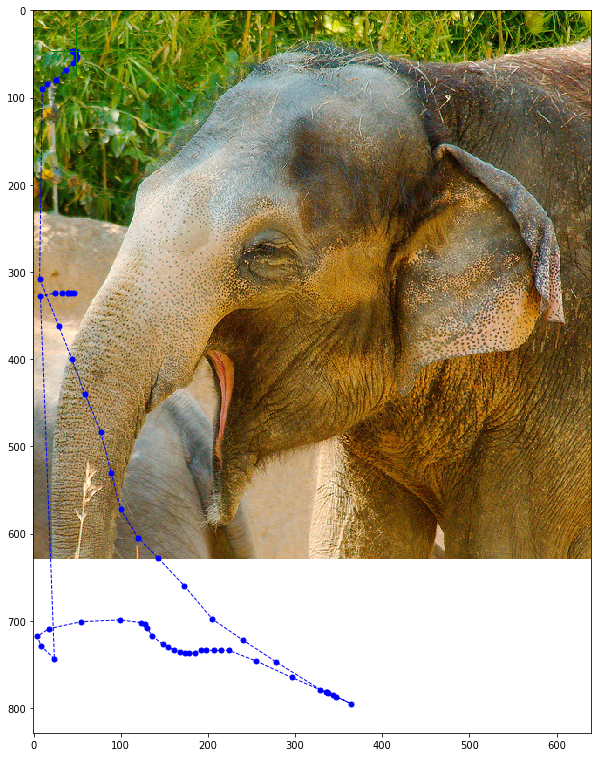

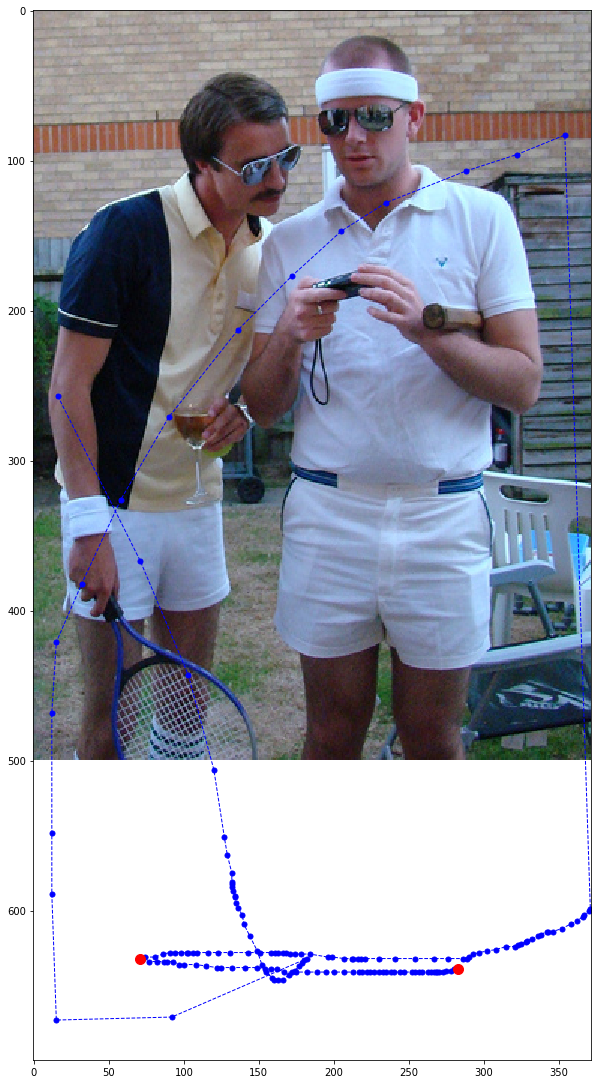

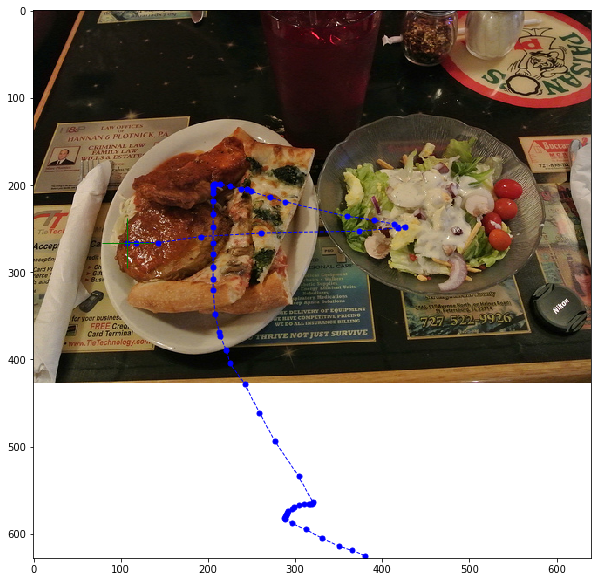

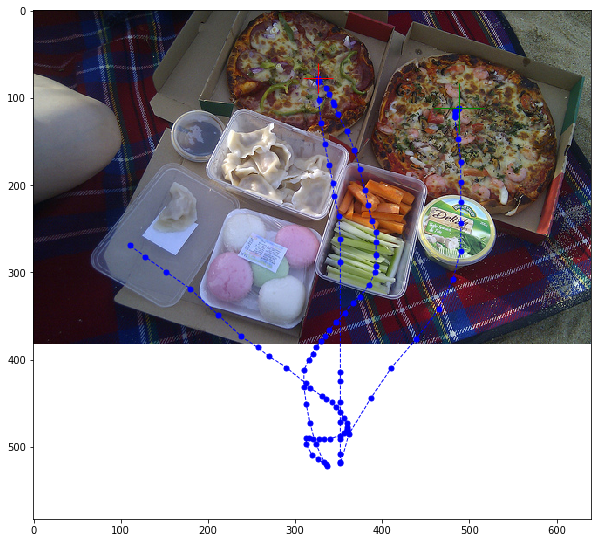

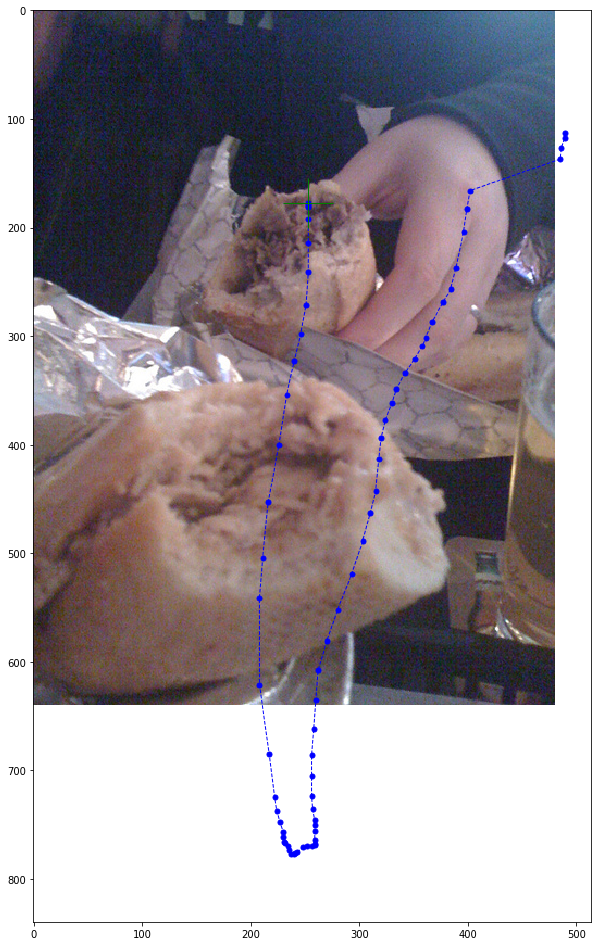

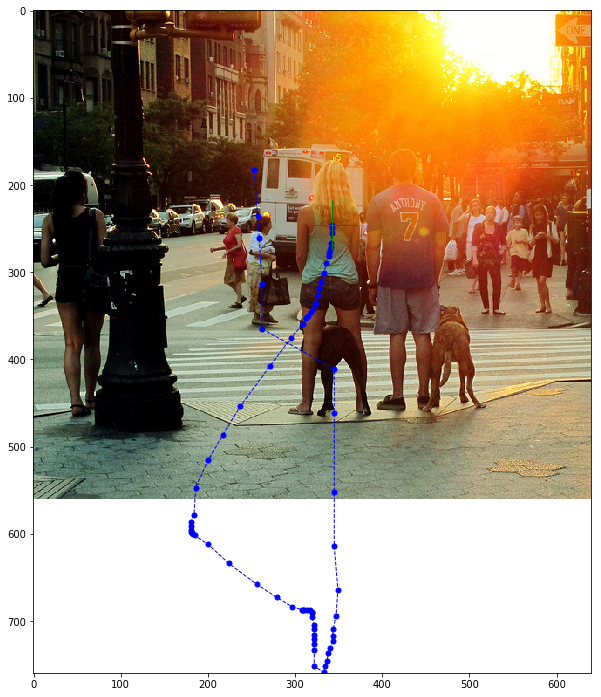

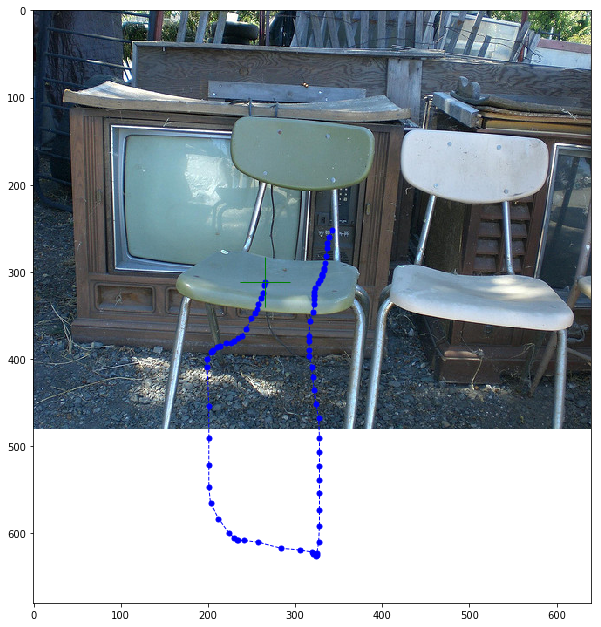

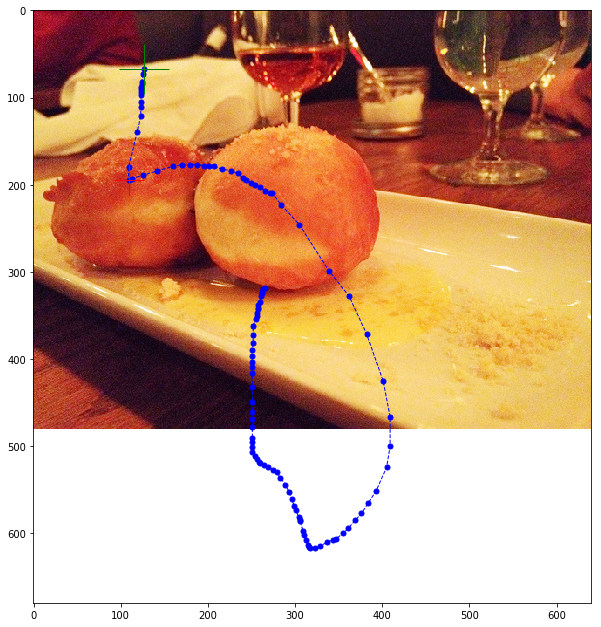

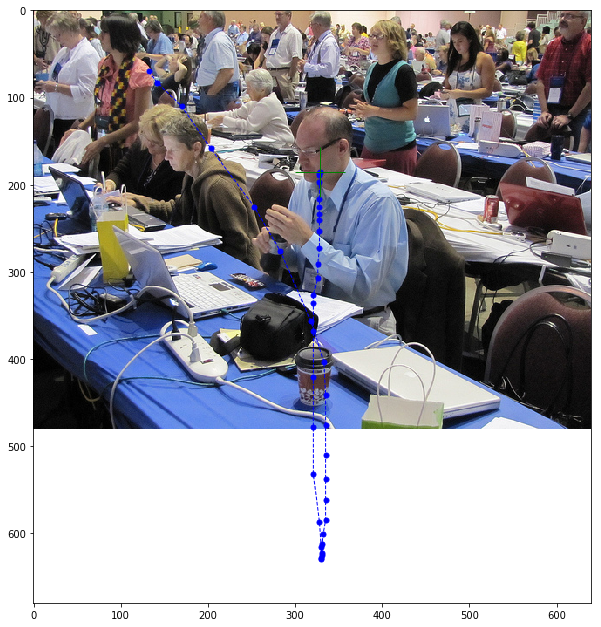

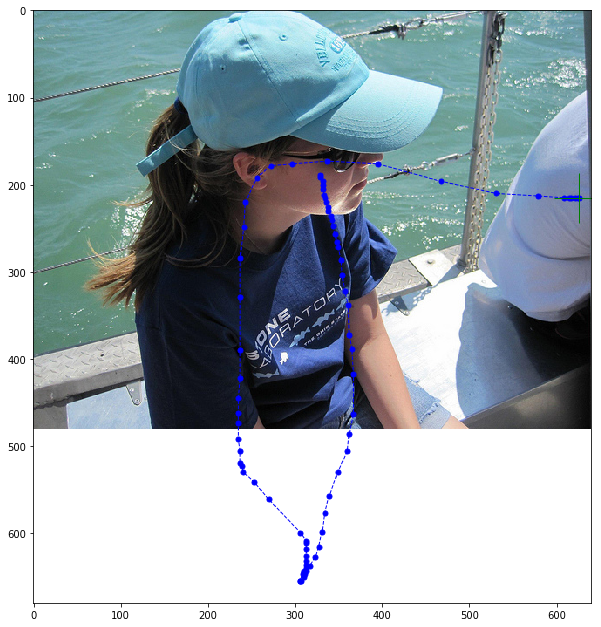

In [13]:
for f in files:
    log_file = read_file(f)
    for i in images_in_log(log_file):
        plot_mouse(i)